In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Carregamento de bibliotecas

In [23]:
from sklearn.svm import SVC
from sklearn.utils import shuffle
from time import time as tick
import numpy as np
import imageio as iio
import math
from joblib import dump, load

### Programa

#### Carregamento de imagens de treino e de teste

In [3]:
dir_training = 'DRIVE/training/images/'
dir_test = 'DRIVE/test/images/'
dir_sol1_test = 'DRIVE/test/1st_manual/'
dir_sol2_test = 'DRIVE/test/2nd_manual/'
dir_mask_training = 'DRIVE/training/new_mask/'
dir_mask_test = 'DRIVE/test/new_mask/'
dir_sol_training = 'DRIVE/training/1st_manual/'

N = 20
training = []
sol_training = []
masks_training = []
test = []
sol1_test = []
sol2_test = []
mask_test = []

for i in range(N):
    
    #training images and masks
    training.append(255-iio.imread(dir_training + str(20+i+1)+'_training.tif')[:,:,1].astype(np.float64))
    #training.append(255-iio.imread(dir_training + str(20+i+1)+'_training.tif')[:,:,1])
    sol_training.append(iio.imread(dir_sol_training + str(20+i+1)+'_manual1.gif'))
    masks_training.append(iio.imread(dir_mask_training + str(20+i+1)+'_training_mask.gif'))
    
    #test images and masks
    if i<9:
        pre = '0'
    else:
        pre = ''
    test.append(255-iio.imread(dir_test + pre +str(i+1)+'_test.tif')[:,:,1].astype(np.float64))
    sol1_test.append(iio.imread(dir_sol1_test + pre  + str(i+1)+'_manual1.gif'))
    sol2_test.append(iio.imread(dir_sol2_test + pre  + str(i+1)+'_manual2.gif'))
    mask_test.append(iio.imread(dir_mask_test + pre +str(i+1)+'_test_mask.gif'))
    
    #plot some images to check
    #if i%5 ==0:
    #    plt.imshow(mask_test[i], cmap = 'gray')
    #    plt.figure()


#### Determinação dos parâmetros das imagens:  line strength, orthogonal line strength e intensidade (x = [S, So, I])

Função que determina as 12 retas cuja inclinação incrementa de 15 graus. Devolve uma matriz 12x15x2 com as coordenadas dos pontos da reta. Faz o mesmo para as respetivas 12 linhas ortogonais de 3 pontos devolvendo uma matriz 12x3x2.

In [4]:
def lines_opt(l = 15, c = 15, centerx = 7, centery = 7, deg_step = 15, n_steps = 12):
    #returns coordinates of the pixels in a 15x15 window correspondent to the lines calculated
    
    lines = np.zeros((l, c), int) 
    lines_plot = np.zeros((n_steps, l, c), int) 
    lines_coord = np.zeros((n_steps, l, 2), int)
    lines_ort_plot = np.zeros((n_steps, l, c), int) 
    lines_ort_coord = np.zeros((n_steps, 3, 2), int)
    
    for i in range(n_steps):
        for j in range(c):
            #evaluate value of funciton y = slope*x where x is the pixel count within the center pixel(0,0)
            j_ = j
            j_ort = j
            
            if deg_step*i<=45 or deg_step*i>=135:
                slope = tan(deg_step*i*math.pi/180.0)
                lines[i, j] = max(min(c-1-round(slope*(j-centerx) + centery), l-1), 0)  
                
            else:
                slope = tan(deg_step*i*math.pi/180.0 - math.pi/2.)
                lines[i,j] = j
                j_ = max(min(round(slope*(lines[i,j]-centerx) + centery), l-1), 0)
            
            lines_plot[i, lines[i, j], j_ ] = 1
            lines_coord[i,j,0] = lines[i, j]
            lines_coord[i,j,1] = j_
            
            
            
    lines_ort_coord[:, :, :] = np.roll(lines_coord[:, centerx-1:centerx+2, :],6,axis=0)
    for i in range(n_steps):
        lines_ort_plot[i][lines_ort_coord[i, :, 0], lines_ort_coord[i, :, 1]] = 1
    
    #print(lines_ort_coord)
    
    i = 0
    _, axs = plt.subplots(2,6,figsize=[12,4],constrained_layout=True)
    _, axs2 = plt.subplots(2,6,figsize=[12,4],constrained_layout=True)
    for il in range(2):
        for ic in range(6):
            axs[il, ic].imshow(lines_plot[i])
            axs[il, ic].set_title(str(i*deg_step) + ' degrees')
            
            axs2[il, ic].imshow(lines_ort_plot[i])
            axs2[il, ic].set_title(str(i*deg_step) + ' degrees')
            i = i + 1    
    
    return lines_coord, lines_ort_coord


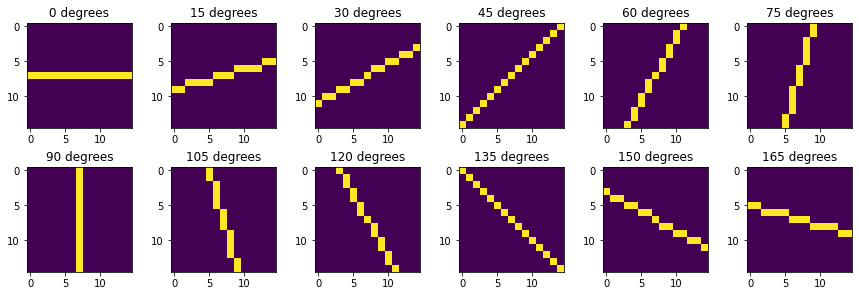

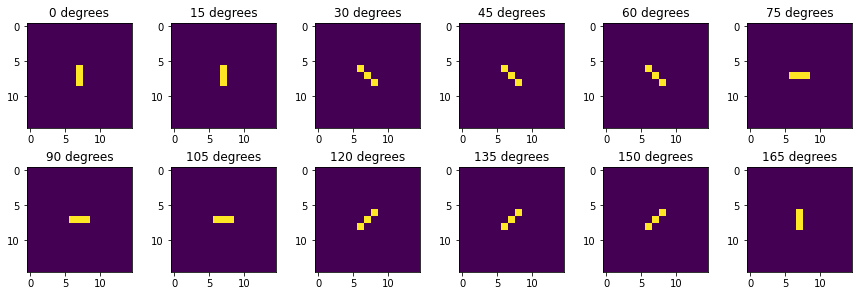

In [5]:
l, l_ort = lines_opt()
#print(l)

##### Verificação do formato e conteúdo das matrizes das linhas

In [6]:
print('Formato da matriz das 12 linhas: ', np.shape(l))
print('Formato da matriz das 12 linhas ortogonais: ', np.shape(l_ort))
print('Pontos da segunda linha (15 graus):')
print(l[1,:,:].transpose())
print('Pontos da segunda linha ortogonal (90+15 graus):')
print(l_ort[1,:,:].transpose())

Formato da matriz das 12 linhas:  (12, 15, 2)
Formato da matriz das 12 linhas ortogonais:  (12, 3, 2)
Pontos da segunda linha (15 graus):
[[ 9  9  8  8  8  8  7  7  7  6  6  6  6  5  5]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]]
Pontos da segunda linha ortogonal (90+15 graus):
[[6 7 8]
 [7 7 7]]


### Cálculo de parâmetros para uma imagem inteira

Função que determina os parâmetros para todos os pontos da imagem passada como argumento, mas somente dentro da retina com base na máscara respetiva que é também passada como argumento. Para o cálculo das features recorre então às coordenadas das linhas previamente calculadas e que seguem como argumento.

In [7]:
def parameters_opt(img_, mask_, sol_,lines, lines_ort):
    
    #constants
    n_lines = 12
    dim = 7
    NL, NC = np.shape(img_)
    print('Image dimensions: ', NL, NC)
    
    #index for the line with greatest intensity: needed for retrieval of correspondent orthogonal
    iline_main = 0
   
    #padding
    img = np.pad(img_, ((dim, dim), (dim, dim)))
    mask = np.pad(mask_, ((dim, dim), (dim, dim)))
    sol = np.pad(sol_, ((dim, dim), (dim, dim)))
    
    #features initialization: should be replaced by simple list, for now they even have the padding shape
    S_test = img.copy()
    I_test = img.copy()
    So_test = img.copy()
    Y_test = img.copy()
    S_test[:] = 0
    So_test[:] = 0
    I_test[:] = 0
    Y_test[:] = 0
        
    #loop trough all the pixels and calculate features
    for i in range(dim, NL+dim):
        for j in range(dim, NC+dim):
            
            #just calculate features for pixels within the retin
            if mask[i,j]!=0:
                
                #retrieve window around pixel for image and mask
                mask_window = mask[i - dim: i + dim + 1, j - dim: j + dim + 1]
                pixel_window = img[i - dim: i + dim + 1, j - dim: j + dim + 1]
                
                #treat border points: fill outside pixels with the remaining's average
                if mask_window[0,0]==0 or mask_window[14,14]==0 or mask_window[0,14]==0 or mask_window[14,0]==0:
                    pixel_window[mask_window == 0] = np.mean(pixel_window[mask_window != 0])
                
                #determine average intensity
                N_ = np.mean(pixel_window)
                
                #retrieve pixel intensity
                I_test[i,j] = img[i,j]
                
                #retrieve solution for that pixel
                Y_test[i,j] = sol[i,j]
                 
                #determine L: greatest intensity level across the lines
                L = np.mean(pixel_window[lines[0,:,0], lines[0,:,1]])
                for i_line in range(1, n_lines):
                    lines_int = pixel_window[lines[i_line,:,0], lines[i_line,:,1]].mean()
                    L_ = L
                    L = max(lines_int, L)
                    if L != L_:
                        iline_main = i_line
                
                #determine S
                S_test[i,j] = L - N_
                
                #retrieve intensity from respective orthogonal line
                Lo = np.mean(pixel_window[lines_ort[iline_main, :, 0], lines_ort[iline_main, :, 1]]) 
                
                #determine So
                So_test[i,j] = Lo - N_
                
    #normalize vector in order to not consider brightness variations
    S_test[mask != 0] = (S_test[mask != 0] - np.mean(S_test[mask != 0]))/np.std(S_test[mask != 0])
    So_test[mask != 0] = (So_test[mask != 0] - np.mean(So_test[mask != 0]))/np.std(So_test[mask != 0])
    I_test[mask != 0] = (I_test[mask != 0] - np.mean(I_test[mask != 0]))/np.std(I_test[mask != 0])
    
    print('Fim')
     
    return S_test, So_test, I_test, Y_test, mask

In [25]:
t1 = time.time()
S_test1_image, So_test1_image, I_test1_image, Y_test1_image, mask_test1_image = parameters_opt(training[0], masks_training[0], sol_training[0], l, l_ort)
t2 = time.time()
print(t2-t1)

Image dimensions:  584 565
Fim
73.86846542358398


##### Verificação do cálculo correto das features

Text(0.5, 1.0, 'Y')

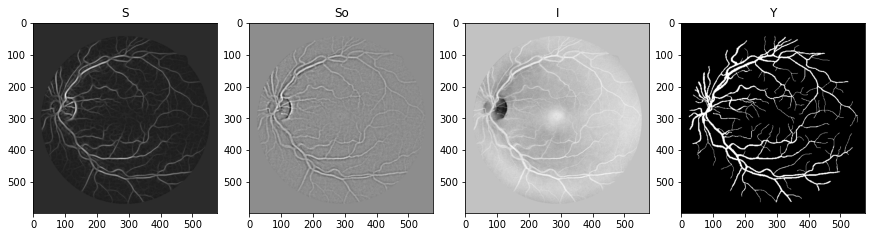

In [10]:
_, axs = plt.subplots(1,4,figsize=[12,12],constrained_layout=True)
axs[0].imshow(S_test1_image, cmap = 'gray')
axs[0].set_title('S')
axs[1].imshow(So_test1_image, cmap = 'gray')
axs[1].set_title('So')
axs[2].imshow(I_test1_image, cmap = 'gray')
axs[2].set_title('I')
axs[3].imshow(Y_test1_image, cmap = 'gray')
axs[3].set_title('Y')

Construir vetor, X e Y, na forma correta

In [11]:
#retrieve only points that are not padding and go from matrix->array
dim = 7
S_test1_f = (S_test1_image[dim:-dim, dim:-dim]).flatten()
So_test1_f = (So_test1_image[dim:-dim, dim:-dim]).flatten()
I_test1_f = (I_test1_image[dim:-dim, dim:-dim]).flatten()
Y_test1_f = (Y_test1_image[dim:-dim, dim:-dim]).flatten()
mask_test1_f = (mask_test1_image[dim:-dim, dim:-dim]).flatten()

#instance....but why?
S_tes1_final = S_test1_f
So_tes1_final = So_test1_f
I_tes1_final = I_test1_f
Y_tes1_final = Y_test1_f
mask_tes1_final = mask_test1_f

#check for initial shapes
print(np.shape(S_tes1_final), np.shape(So_tes1_final),np.shape(I_tes1_final),np.shape(Y_tes1_final))

#how many points should be used for testing: every point but the ones outside retin
length = np.shape(S_tes1_final)[0] - np.shape(I_test1_f[mask_tes1_final==0])[0]
print(length)
print('Pontos iniciais totais: ', np.shape(S_tes1_final)[0])
print('Pontos removidos: ',np.shape(I_test1_f[mask_test1_f==0])[0])
print('Pontos removidos em baixo: ',np.shape(I_tes1_final[mask_tes1_final==0])[0])
print('Pontos aceites no final: ', np.shape(S_tes1_final[mask_tes1_final!=0])[0])

X_image = np.zeros((length, 3), float)
Y_image = np.zeros((length), float)

X_image[:,0] = S_tes1_final[mask_tes1_final!=0]
X_image[:,1] = So_tes1_final[mask_tes1_final!=0]
X_image[:,2] = I_tes1_final[mask_tes1_final!=0]
Y_image[:] = Y_tes1_final[mask_tes1_final!=0]

print(X_image)
print(Y_image)

(329960,) (329960,) (329960,) (329960,)
220500
Pontos iniciais totais:  329960
Pontos removidos:  109460
Pontos removidos em baixo:  109460
Pontos aceites no final:  220500
[[-0.57922585 -0.65297232 -0.24950493]
 [-0.63241751 -0.38844799  0.1193516 ]
 [-0.59545862 -0.0771794   0.26689421]
 ...
 [-0.39044051 -0.06207802 -0.17573362]
 [-0.42812932 -0.10448905 -0.24950493]
 [-0.49301241 -0.14088851 -0.47081884]]
[0. 0. 0. ... 0. 0. 0.]


####  Fazer o mesmo mas para todas as imagens, de treino e de teste

##### Treino

In [ ]:
#Lists to store the features from all the images
X_training = []
Y_training = []

for i in range(N):
    
    #Feature calculation
    print('Image ', str(i), '. Feature calculation time: ', end = ' ')
    t1 = time.time()
    S1_training, So1_training, I1_training, Y1_training, mask1_training = parameters_opt(training[0], masks_training[0], sol_training[0], l, l_ort)
    t2 = time.time()
    print(t2-t1)
    
    #Reformatting of the features
    

##### Teste

### Pontos random para treino

Função que sorteia os pontos dos quais se vão determinar os pârametros da imagem.

In [12]:
def random_pixels(mask, NL, NC, N):
    li, lj = [], []
    while True:
        i = randint(0, NL)
        j = randint(0, NC)
        
        if mask[i,j]>0:
            li.append(i)
            lj.append(j)
            if len(li)>N:
                break
    return li, lj

Função que determina as features dos N pontos aleatórios para treino da imagem passada como argumento. À semelhança da que calculava para a imagem toda, recebe também a respetiva máscara e solução.

In [13]:
def parameters_opt_random(img_, mask_, sol_, lines, lines_ort, N = 1000):
    
    #constants
    n_lines = 12
    dim = 7
    NL, NC = np.shape(img_)
    print(NL, NC)
    
    #index for the line with greatest intensity: needed for retrieval of correspondent orthogonal
    iline_main = 0

    #padding
    img = np.pad(img_, ((dim, dim), (dim, dim)))
    mask = np.pad(mask_, ((dim, dim), (dim, dim)))
    sol = np.pad(sol_, ((dim, dim), (dim, dim)))
    
    #features initialization
    S = []
    So = []
    I = []
    Y = []    
    
    #random picking of pixels 
    li, lj = random_pixels(mask, NL + dim*2, NC + dim*2, N)
    
    #counter for control of pixels done
    count = 0    
    
    #loop through all the N pixels
    for j in range(N):
        
            #control print
            if count%50==0:
                print("Hello", str(count), end =" ")
            
            #retrieve window around pixel for image and mask
            mask_window = mask[li[j] - dim: li[j] + dim + 1, lj[j] - dim: lj[j] + dim + 1]
            pixel_window = img[li[j] - dim: li[j] + dim + 1, lj[j] - dim: lj[j] + dim + 1]
            
            #treat border points: fill outside pixels with the remaining's average
            if mask_window[0,0]==0 or mask_window[14,14]==0 or mask_window[0,14]==0 or mask_window[14,0]==0:
                pixel_window[mask_window == 0] = np.mean(pixel_window[mask_window != 0])
            
            #determine average intensity
            N_ = np.mean(pixel_window)
            
            #retrieve pixel intensity
            I.append(img[li[j],lj[j]])
            
            #retrieve pixel solution
            Y.append(sol[li[j],lj[j]])
             
            #determine L: greatest intensity level across the lines
            L = np.mean(pixel_window[lines[0,:,0], lines[0,:,1]])
            for i_line in range(1, n_lines):
                lines_int = pixel_window[lines[i_line,:,0], lines[i_line,:,1]]
                L_ = L
                L = max(np.mean(lines_int), L)
                if L != L_:
                    iline_main = i_line
            #determine S           
            S.append(L - N_)
            
            #retrieve intensity from respective orthogonal line
            Lo = np.mean(pixel_window[lines_ort[iline_main, :, 0], lines_ort[iline_main, :, 1]]) 
            
            #determine So
            So.append(Lo - N_)
            
            count = count + 1
                
    #normalize vector to not consider brightness variations
    S = (S - np.mean(S))/np.std(S)
    So = (So - np.mean(So))/np.std(So)
    I = (I - np.mean(I))/np.std(I)
    
    print('Fim')
     
    return S, So, I, Y

In [14]:
n = 1000
print(N)
X = np.zeros((N*n, 3), float)
Y = np.zeros((N*n), float)

for i in range(N):
    S_test, So_test, I_test, Y_test = parameters_opt_random(training[i], masks_training[i], sol_training[i], l, l_ort)
    X[i*n:(i+1)*n, 0] = S_test
    X[i*n:(i+1)*n, 1] = So_test
    X[i*n:(i+1)*n, 2] = I_test
    Y[i*n:(i+1)*n] = Y_test

20
584 565
Hello 0 Hello 50 Hello 100 Hello 150 Hello 200 Hello 250 Hello 300 Hello 350 Hello 400 Hello 450 Hello 500 Hello 550 Hello 600 Hello 650 Hello 700 Hello 750 Hello 800 Hello 850 Hello 900 Hello 950 Fim
584 565
Hello 0 Hello 50 Hello 100 Hello 150 Hello 200 Hello 250 Hello 300 Hello 350 Hello 400 Hello 450 Hello 500 Hello 550 Hello 600 Hello 650 Hello 700 Hello 750 Hello 800 Hello 850 Hello 900 Hello 950 Fim
584 565
Hello 0 Hello 50 Hello 100 Hello 150 Hello 200 Hello 250 Hello 300 Hello 350 Hello 400 Hello 450 Hello 500 Hello 550 Hello 600 Hello 650 Hello 700 Hello 750 Hello 800 Hello 850 Hello 900 Hello 950 Fim
584 565
Hello 0 Hello 50 Hello 100 Hello 150 Hello 200 Hello 250 Hello 300 Hello 350 Hello 400 Hello 450 Hello 500 Hello 550 Hello 600 Hello 650 Hello 700 Hello 750 Hello 800 Hello 850 Hello 900 Hello 950 Fim
584 565
Hello 0 Hello 50 Hello 100 Hello 150 Hello 200 Hello 250 Hello 300 Hello 350 Hello 400 Hello 450 Hello 500 Hello 550 Hello 600 Hello 650 Hello 700 Hello 

#### Criar o classificador

In [15]:
clf1 = SVC(kernel='rbf', gamma=0.05)

#### Treinar o classificador

In [16]:
t1 = time.time()
clf1 = clf1.fit(X, Y)
t2 = time.time()
print(t2-t1)

5.81644082069397


#### Prever resultado

In [17]:
t1 = time.time()
y_pred_train = clf1.predict(X_image)
t2 = time.time()
print(t2-t1)

142.92191910743713


#### Calcular taxa de sucesso

In [18]:
print("Taxa de sucesso (Treino): ",
      np.mean(y_pred_train == Y_image) * 100)

from sklearn.metrics import confusion_matrix 

tn, fp, fn, tp = confusion_matrix(Y_image, y_pred_train).ravel()
print((tp+tn)/(tp+tn+fp+fn))
print('tn: ', tn, 'fp: ', 'fp: ', fp, 'fn: ', fn, 'tp: ', tp)

Taxa de sucesso (Treino):  94.46666666666667
0.9446666666666667
tn:  188916 fp:  fp:  2318 fn:  9883 tp:  19383


#### Verificar visualmente resultados

Text(0.5, 1.0, 'Solution from MOI')

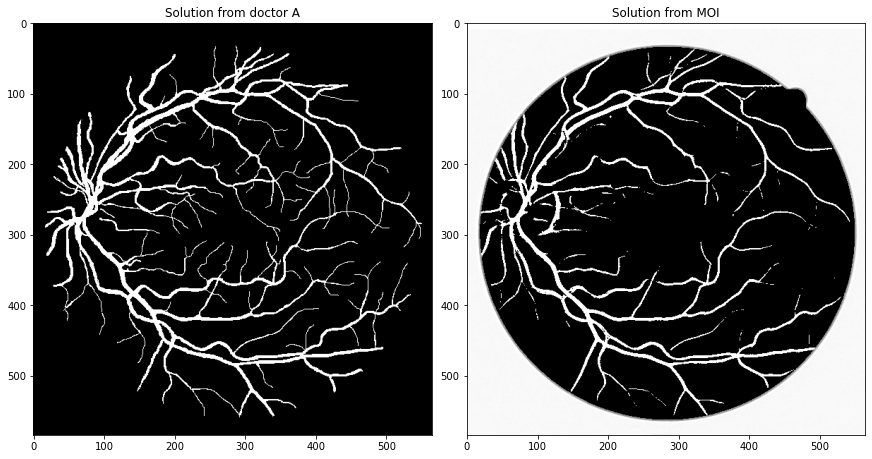

In [21]:
_, axs = plt.subplots(1,2,figsize=[12,12],constrained_layout=True)
axs[0].imshow(sol1_test[0],cmap = 'gray')
axs[0].set_title('Solution from doctor A')

img_copy = test[0].copy()
img_copy[mask_test[0]>0] =y_pred_train 
axs[1].imshow(img_copy,cmap = 'gray')
axs[1].set_title('Solution from MOI')

(584, 565, 3)
[[1.85333333 1.30666667 2.06666667 ... 1.39111111 1.53777778 1.13333333]
 [2.42222222 2.76       2.37333333 ... 1.52       0.80444444 0.35555556]
 [5.48888889 4.23555556 4.26666667 ... 0.46666667 0.10666667 0.62222222]
 ...
 [2.81777778 3.03111111 1.88888889 ... 2.55111111 2.71555556 2.79555556]
 [2.13333333 1.95111111 0.76       ... 2.63555556 2.96888889 2.84      ]
 [1.78666667 0.90222222 0.12444444 ... 2.81777778 2.61333333 2.34222222]]
[[ 75.91278059  68.21511199  78.91674882 ...  81.04455965  80.16840225
   87.86607085]
 [ 83.92336254  88.67964558  83.23495316 ...  84.48660659  82.35879575
   88.11640154]
 [127.10540591 109.45709253 109.89517123 ...  78.66641813  83.48528384
   86.36408673]
 ...
 [ 81.42005568  76.41344196  70.34292282 ...  66.71312787  62.26975819
   52.88235746]
 [ 69.52934809  66.27504917  66.02471848 ...  74.91145784  67.5267026
   67.21378924]
 [ 81.42005568  82.10846507  71.59457625 ...  72.34556831  72.22040296
   71.53199358]]


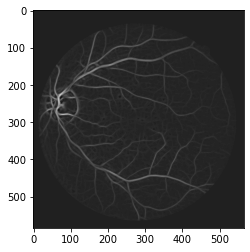

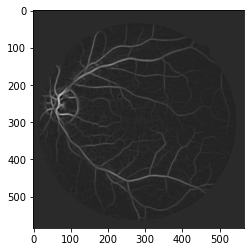

In [36]:
tiago_train1 = load('car_S_So_I_train1')
print(np.shape(tiago_train1))
plt.imshow(tiago_train1[:,:,0], cmap = 'gray')
plt.figure()
plt.imshow(S_test1_image[dim:-dim,dim:-dim], cmap = 'gray')

np.allclose((tiago_train1[:,:,0])[masks_training[0]>0], (S_test1_image[dim:-dim,dim:-dim])[masks_training[0]>0], 1)

print(tiago_train1[200:300,200:300,0])
print((S_test1_image[200+dim:300-dim,200+dim:300-dim] - np.min(S_test1_image[200:300,200:300]))/np.max(S_test1_image[200:300,200:300])*255)